### Project 4
Build a statistical risk model using PCA. You'll use this model to build a portfolio along with 5 alpha factors. You'll create these factors, then evaluate them using factor-weighted returns, quantil analysis, sharpe ratio, and turnover analysis. 

At the end of the project, you'll optimize the p;ortfolio using the risk model and factors using multiple optimization formations. 

In [1]:
# Imports
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.data import morningstar as mstar
from quantopian.pipeline.factors import AverageDollarVolume
from quantopian.pipeline.factors.morningstar import MarketCap
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.factors import Returns
from zipline.pipeline.factors import DailyReturns


import numpy as np
import pandas as pd
from pandas import DataFrame as df
import time
import cvxpy as cvx
import matplotlib.pyplot as plt

from quantopian.pipeline.experimental import QTradableStocksUS

In [2]:
def make_pipeline():
    average_day_dv_200 = AverageDollarVolume(window_length = 200)
    market_cap = Fundamentals.market_cap.latest
    price_open = USEquityPricing.open.latest
    price_close = USEquityPricing.close.latest
    volume = USEquityPricing.volume.latest
    sector = Sector()
    daily_returns = DailyReturns(inputs = [USEquityPricing.close])
    
    # Ranked Returns
    returns = Returns(window_length=252)
    ranked_retuns = returns.rank()
    
    five_yr_return = Returns(window_length=1260)
    
    universe = AverageDollarVolume(window_length=120).top(500) 
    
    # New Factors
    # create a factor of 1 year returns, demeaned by sector, rank, zscore
    factor = (
    Returns(window_length=252).\
    demean(groupby = Sector()).\
    rank().\
    zscore()
    )
    
    # use the newly created factor as an input into SimpleMovingAverage, with window length = 5
    factor_smoothed = (SimpleMovingAverage(inputs = [factor], window_length=5).\
                      rank().\
                      zscore()
                      )
    
    return Pipeline(
        columns = {
            'AverageDollarVolume': average_day_dv_200,
            'MarketCap': market_cap,
            'close_price':price_close,
            'open_price':price_open,
            'volume':volume,
            'sector':sector,
            '1yrReturns': factor,
            '5dAvgReturns': factor_smoothed,
            'ranked_returns':ranked_retuns,
            '1dReturns':daily_returns,
            '5yReturns': five_yr_return
        },
        screen = universe
    )

In [3]:
# pipeline is run over this time range and outputs a dataframe indexed by asset name:
start_date = '2013'
end_date = '2019-08-03'

QTU_pipeline2 = run_pipeline(make_pipeline(), start_date, end_date, chunksize=252)

### Create individual custom dataframes

In [4]:
universe = AverageDollarVolume(window_length=120).top(500) 

In [5]:
df_momentum = QTU_pipeline2[['1yrReturns', '5dAvgReturns']]
df_price = QTU_pipeline2[['close_price']]
df_returns = QTU_pipeline2[['1dReturns']]

df_price = df_price.close_price.unstack().fillna(0)
df_returns = df_returns['1dReturns'].unstack().fillna(0)

In [6]:
df_returns.describe()

,Equity(2 [ARNC]),Equity(24 [AAPL]),Equity(53 [ABMD]),Equity(62 [ABT]),Equity(64 [GOLD]),Equity(67 [ADSK]),Equity(76 [TAP]),Equity(88 [ACI]),Equity(114 [ADBE]),Equity(122 [ADI]),...,Equity(52424 [ELAN]),Equity(52592 [LIN]),Equity(52747 [DELL]),Equity(52968 [FOXA]),Equity(52991 [DOW]),Equity(53023 [LYFT]),Equity(53089 [PINS]),Equity(53095 [ZM]),Equity(53116 [BYND]),Equity(53158 [UBER])
count,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,...,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000,1659.000000
mean,0.000300,0.000822,-0.000367,0.000779,0.000051,0.000900,0.000172,-0.000185,0.001386,0.000747,...,0.000008,0.000122,0.000011,0.000008,-0.000050,0.000012,0.000095,0.000017,0.000468,-0.000028
std,0.020241,0.015837,0.013516,0.012529,0.027334,0.019470,0.010144,0.007629,0.016488,0.014700,...,0.003778,0.003780,0.000459,0.001541,0.003582,0.006300,0.004472,0.003246,0.015537,0.003489
min,-0.346214,-0.123541,-0.263727,-0.092661,-0.158793,-0.158395,-0.064785,-0.129870,-0.082793,-0.078109,...,-0.034535,-0.029697,0.000000,-0.019383,-0.037332,-0.108527,-0.023095,-0.055545,-0.251570,-0.040529
25%,-0.005101,-0.006553,0.000000,-0.005532,-0.013975,-0.007351,0.000000,0.000000,-0.006460,-0.004849,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000755,0.000000,0.000601,0.000000,0.000000,0.000000,0.000000,0.001299,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.005973,0.009180,0.000000,0.007839,0.013920,0.009446,0.000000,0.000000,0.009506,0.007127,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.131980,0.082003,0.101758,0.065540,0.130973,0.153705,0.141265,0.083495,0.127963,0.101614,...,0.053748,0.048111,0.018713,0.018653,0.040829,0.070071,0.180663,0.068781,0.392367,0.060414


### Statistical Risk Model
It's time to build the risk model. You'll be createing a statistical risk model using PCA. So, the first thing is building the PCA model.

### Fit PCA
Implement `fit_pca` to fit a PCA model to the returns data

In [7]:
from sklearn.decomposition import PCA

In [8]:
def fit_pca(df, num_factor_exposures, svd_solver):
    """
    Fit PCA model with returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    num_factor_exposures : int
        Number of factors for PCA
    svd_solver: str
        The solver to use for the PCA model

    Returns
    -------
    pca : PCA
        Model fit to returns
    """
    #TODO: Implement function
    # L25-18: Todo Perform PCA
    #pca = PCA(n_components=num_factor_exposures, svd_solver = 'svd_solver')
    
    # dont know why, but quantopian does not let you input the svd_solver = 'svd_solver'
    pca = PCA(n_components=num_factor_exposures)
    pca.fit(df)
    
    return pca

### View Data
Let's see what the model looks like. First we'll look a the PCA components

In [9]:
num_factor_exposures = 20
pca = fit_pca(df_returns, num_factor_exposures, 'full')

pca.components_

array([[ -6.40069571e-05,  -7.70274282e-04,  -1.94095335e-03, ...,
         -2.75700509e-07,   9.96572622e-06,  -3.37234483e-06],
       [  4.09609256e-02,   3.84709249e-02,   1.33217974e-02, ...,
          1.37362924e-04,   1.19445074e-03,   4.07919673e-04],
       [ -3.55475325e-02,   1.68779179e-02,   1.09883167e-02, ...,
          4.83669431e-04,   4.78170147e-03,   6.13026671e-04],
       ..., 
       [ -3.98033722e-02,  -1.21184271e-02,  -3.32646617e-02, ...,
         -2.40482590e-03,  -1.67396763e-02,  -3.18150838e-03],
       [  9.19614740e-03,   1.14218870e-02,   2.17146424e-02, ...,
         -3.82513344e-04,  -5.21097839e-03,   2.13564685e-03],
       [ -5.40712273e-02,   2.70917293e-02,  -1.98762370e-02, ...,
         -1.28127964e-03,  -4.91893340e-03,  -6.67404944e-03]])

In [10]:
len(pca.components_)

20

Lets also look at the PCA's percent of variance explained by each factor

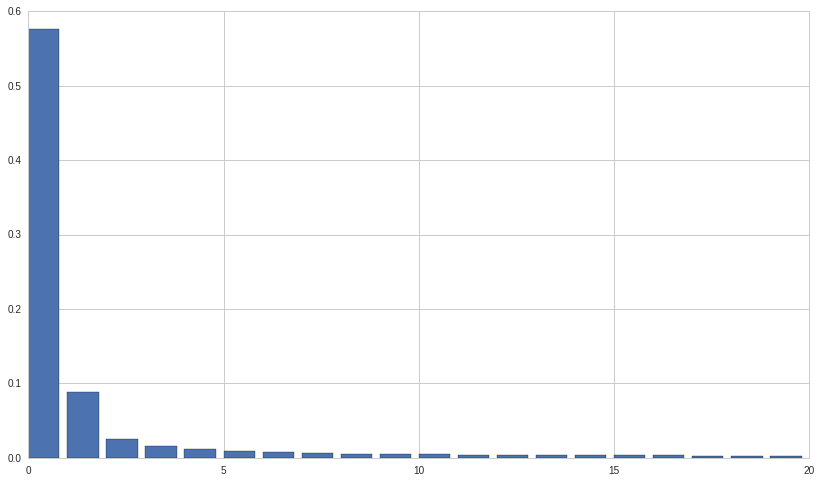

In [11]:
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_);

You will see tht hte first factor dominates. This precise definition of each factor is a latent model is unknown; however, we can guess at the likely interpretation.

### Factor Betas
Implement `factor_betas` to get the factor betas from the PCA model.

In [12]:
def factor_betas(pca, factor_beta_indices, factor_beta_columns):
    """
    Get the factor betas from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    factor_beta_indices : 1 dimensional Ndarray
        Factor beta indices
    factor_beta_columns : 1 dimensional Ndarray
        Factor beta columns

    Returns
    -------
    factor_betas : DataFrame
        Factor betas
    """
    assert len(factor_beta_indices.shape) == 1
    assert len(factor_beta_columns.shape) == 1
    
    #TODO: Implement function 
    #L25-18: Factor Exposures
    
    return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)

### View Data
Let's view the factor betas from this model.

In [13]:
risk_model = {}
risk_model['factor_betas'] = factor_betas(pca, df_returns.columns.values, np.arange(num_factor_exposures))

risk_model['factor_betas']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Equity(2 [ARNC]),-6.400696e-05,0.040961,-0.035548,0.026952,-0.019416,0.046251,-0.005391,2.275293e-03,-0.001842,0.038786,-0.074126,0.006267,-0.014995,0.029744,-0.031043,0.008703,0.058165,-0.039803,0.009196,-0.054071
Equity(24 [AAPL]),-7.702743e-04,0.038471,0.016878,-0.020954,0.021546,-0.018996,-0.018345,1.931126e-03,0.033770,0.030010,0.003936,-0.004732,-0.003257,-0.004874,-0.011548,0.031151,0.015175,-0.012118,0.011422,0.027092
Equity(53 [ABMD]),-1.940953e-03,0.013322,0.010988,-0.010344,0.023828,-0.062393,-0.040465,-1.109655e-02,0.006944,0.002530,0.028591,-0.025609,-0.007944,-0.016306,-0.014936,-0.010909,-0.033393,-0.033265,0.021715,-0.019876
Equity(62 [ABT]),-5.402134e-04,0.036402,0.017537,-0.020229,-0.015408,-0.000069,-0.003747,1.290155e-02,-0.019050,0.010520,0.035708,0.000041,0.028545,-0.019168,-0.027518,0.004656,-0.026053,-0.006433,-0.004001,0.006577
Equity(64 [GOLD]),2.346706e-04,0.016024,-0.175560,-0.125016,-0.015910,0.009733,-0.014927,-2.947465e-02,-0.022846,-0.010219,-0.042995,-0.041700,-0.043616,-0.025794,-0.047943,0.004960,0.012392,0.015305,0.018376,-0.008328
Equity(67 [ADSK]),-2.278197e-03,0.053860,0.021234,-0.031339,0.025289,-0.019885,-0.048055,-3.207613e-03,0.038153,0.035063,-0.009390,0.016051,-0.018849,0.000251,0.002150,0.007762,0.000068,-0.013500,0.007187,-0.031609
Equity(76 [TAP]),2.577229e-05,0.010036,-0.001797,-0.003681,-0.003654,0.004071,0.018152,1.099567e-02,0.001086,0.011404,0.023951,0.010409,0.007774,0.010402,0.015837,-0.012760,0.023280,-0.005509,-0.016156,0.001901
Equity(88 [ACI]),-1.163141e-05,0.001879,-0.002241,0.002104,-0.004060,0.002969,0.001447,-1.651333e-02,0.003109,-0.005714,-0.008174,0.004501,0.002613,-0.002128,-0.003405,-0.000642,0.006833,0.001342,0.021710,-0.013559
Equity(114 [ADBE]),-1.367129e-03,0.046516,0.023534,-0.037014,0.009727,-0.014427,-0.042760,1.254122e-02,0.047595,0.036857,0.042450,-0.002410,-0.027222,0.004953,0.000230,-0.006868,-0.019292,-0.003847,-0.022232,-0.028028
Equity(122 [ADI]),-8.537392e-04,0.039927,0.015682,-0.017784,0.012216,-0.019286,-0.030296,-4.765481e-03,0.015279,0.036732,-0.021380,-0.014726,0.000514,0.001649,-0.007026,0.080184,0.057241,-0.014820,0.058259,0.060778


### Factor Returns
Implement `factor_returns` to get the factor returns from teh PCA model using the returns data.

In [14]:
def factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    """
    Get the factor returns from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    returns : DataFrame
        Returns for each ticker and date
    factor_return_indices : 1 dimensional Ndarray
        Factor return indices
    factor_return_columns : 1 dimensional Ndarray
        Factor return columns

    Returns
    -------
    factor_returns : DataFrame
        Factor returns
    """
    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1
    
    #TODO: Implement function
    #L25-18: Factor Returns
    
    return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)

### View Data
Let's see what these factor returns looks like over time

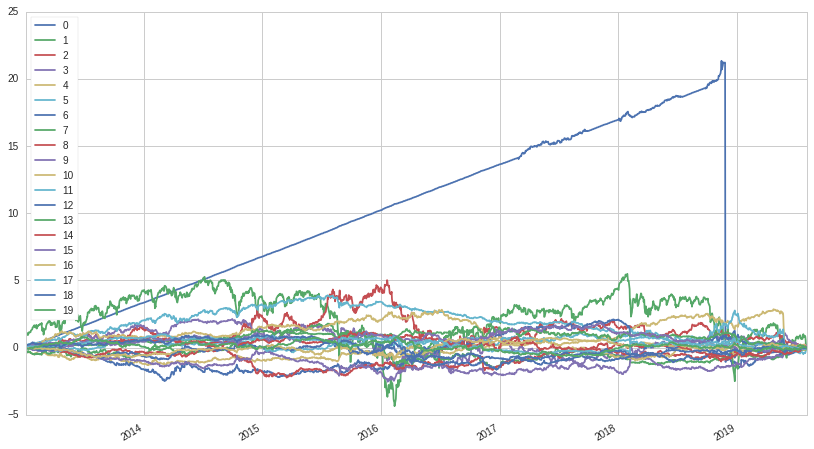

In [15]:
risk_model['factor_returns'] = factor_returns(
    pca,
    df_returns,
    df_returns.index,
    np.arange(num_factor_exposures))

risk_model['factor_returns'].cumsum().plot();

### Factor Covariance Matrix
Implement `factor_cov_matrix` to get the factor covariance matrix

In [16]:
def factor_cov_matrix(factor_returns, ann_factor):
    """
    Get the factor covariance matrix

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns
    ann_factor : int
        Annualization factor

    Returns
    -------
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    """
    
    #TODO: Implement function
    #L25-18: Factor Covariance Matrix
    
    return np.diag(factor_returns.var(axis=0, ddof=1) * ann_factor)

### View Data

In [17]:
ann_factor = 252
risk_model['factor_cov_matrix'] = factor_cov_matrix(risk_model['factor_returns'], ann_factor=ann_factor)

risk_model['factor_cov_matrix']

array([[ 75.78806117,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,  11.60857681,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   3.38013866,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  

### Idiosyncratic VAriance Matrix
Implement `idiosyncratic_var_matrix` to get the idiosyncratic variance matrix

In [18]:
def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    """
    Get the idiosyncratic variance matrix

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    factor_returns : DataFrame
        Factor returns
    factor_betas : DataFrame
        Factor betas
    ann_factor : int
        Annualization factor

    Returns
    -------
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    """
    
    #TODO: Implement function
    #L25-18: Idiosyncratic Risk Matrix
    common_returns_ = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    residuals_ = (returns - common_returns_)
    idiosyncratic_var_matrix = pd.DataFrame(np.diag(np.var(residuals_))*ann_factor, returns.columns, returns.columns)
    
    return idiosyncratic_var_matrix

### View Data

In [19]:
risk_model['idiosyncratic_var_matrix'] = idiosyncratic_var_matrix(df_returns, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)
risk_model['idiosyncratic_var_matrix']

,Equity(2 [ARNC]),Equity(24 [AAPL]),Equity(53 [ABMD]),Equity(62 [ABT]),Equity(64 [GOLD]),Equity(67 [ADSK]),Equity(76 [TAP]),Equity(88 [ACI]),Equity(114 [ADBE]),Equity(122 [ADI]),...,Equity(52424 [ELAN]),Equity(52592 [LIN]),Equity(52747 [DELL]),Equity(52968 [FOXA]),Equity(52991 [DOW]),Equity(53023 [LYFT]),Equity(53089 [PINS]),Equity(53095 [ZM]),Equity(53116 [BYND]),Equity(53158 [UBER])
Equity(2 [ARNC]),0.066202,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
Equity(24 [AAPL]),0.000000,0.040184,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
Equity(53 [ABMD]),0.000000,0.000000,0.033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
Equity(62 [ABT]),0.000000,0.000000,0.000,0.019328,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
Equity(64 [GOLD]),0.000000,0.000000,0.000,0.000000,0.041111,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
Equity(67 [ADSK]),0.000000,0.000000,0.000,0.000000,0.000000,0.051263,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
Equity(76 [TAP]),0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.023117,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
Equity(88 [ACI]),0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.013982,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
Equity(114 [ADBE]),0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031398,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
Equity(122 [ADI]),0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024344,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000


### Idiosyncratic Variance Vector
Implement `idiosyncratic_variance_vector` to get the idiosyncratic variance Vector

In [20]:
def idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    """
    Get the idiosyncratic variance vector

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix

    Returns
    -------
    idiosyncratic_var_vector : DataFrame
        Idiosyncratic variance Vector
    """
    
    #TODO: Implement function
    idiosyncratic_variance_vector = pd.DataFrame(np.diag(idiosyncratic_var_matrix), returns.columns)
    
    return idiosyncratic_variance_vector

### View Data

In [21]:
risk_model['idiosyncratic_var_vector'] = idiosyncratic_var_vector(df_returns, risk_model['idiosyncratic_var_matrix'])
risk_model['idiosyncratic_var_vector']

,0
Equity(2 [ARNC]),0.066202
Equity(24 [AAPL]),0.040184
Equity(53 [ABMD]),0.033000
Equity(62 [ABT]),0.019328
Equity(64 [GOLD]),0.041111
Equity(67 [ADSK]),0.051263
Equity(76 [TAP]),0.023117
Equity(88 [ACI]),0.013982
Equity(114 [ADBE]),0.031398
Equity(122 [ADI]),0.024344


### Predict using the Risk Model
Using the data we calculated in the risk model, implement `predict_portfolio_risk` to predict the portfolio risk using the formula $\sqrt{X^{T}(BFB^{T} + S)X}$ where:

- $X$ is the portfolio weights
- $B$ is the factor betas
- $F$ is the factor covariance matrix
- $S$ is the idiosyncratic variance matrix

In [22]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    """
    Get the predicted portfolio risk
    
    Formula for predicted portfolio risk is sqrt(X.T(BFB.T + S)X) where:
      X is the portfolio weights
      B is the factor betas
      F is the factor covariance matrix
      S is the idiosyncratic variance matrix

    Parameters
    ----------
    factor_betas : DataFrame
        Factor betas
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    weights : DataFrame
        Portfolio weights

    Returns
    -------
    predicted_portfolio_risk : float
        Predicted portfolio risk
    """
    assert len(factor_cov_matrix.shape) == 2
    
    #TODO: Implement function
    df = np.sqrt(weights.T.dot(factor_betas.dot(factor_cov_matrix).dot(factor_betas.T) + idiosyncratic_var_matrix).dot(weights))
    
    return df[0][0]

### View Data
Let's see what the portfolio risk would be if we had even weights across all stocks

In [23]:
universe_tickers = risk_model['factor_betas'].index.tolist()
all_weights = pd.DataFrame(np.repeat(1/len(universe_tickers), len(universe_tickers)), universe_tickers)

predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.0

### Create Alpha Factors
With the profile risk calculated, it's time to start working on the alpha factors. In this project, we'll create the following factors:

* momentum 1 yr factor
* mean reversion 5 day sector neutral factor
* mean reversion 5 day sector neutral smooted factor
* overnight sentiment factor
* overnight sentiment smoothed factor

### Momentum 1 year factor
Ech factor will have a hypothesis that goes with it. For this factor, it is "higher pas 12-month (252 days) returns are proportional to future returns". Using that hypothesis we've generated this code.

In [24]:
def momentum_1yr(window_length, universe, sector):
    return Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()

### Mean Reversion 5 day Sector Neutral Factor
Now it's time for you to implement `mean_reversion_5day_sector_neutral` using the hypothesis "short-term outperformers(underperformers) compared to their sector will revert". Use the returns data from `universe`, demean using the sector data to partition, rank, then covert to a zscore.

In [25]:
def mean_reversion_5day_sector_neutral(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral factor
    """
    
    #TODO: Implement function
    
    factor = -Returns(window_length = window_length, mask=universe).demean(groupby=Sector()).rank().zscore()
    
    return factor

    
#     return Pipeline(
#         columns = {
#             'Mean_Reversion_5Day_Sector_Neutral':factor
#         },
#     screen = universe)

### View Data
Let's see what some of the factor data looks like. For calculating factors, we'll be looking back 2 years

**Note:** Going back 2 years falls on a day wehn the market is closed. Pipeline package doesn't handle start or end dates that dont fall on days when the market is open. To fix this, we went back 2 extra days to fall on the next day when the market is open.

In [26]:
# start_date = '2016'
# end_date = '2019-08-02'
# window_length = 5
# sector = Sector()
# df_mean_reversion = run_pipeline(mean_reversion_5day_sector_neutral(window_length, universe, sector), start_date, end_date, chunksize=252)

In [27]:
# df_mean_reversion

### Mean Reversion 5 Day Sector Neutral Smooted Factor
Taking the output of the previous factor, let's create a smootehed version. Implement `mean_refersion_5day_sector_neutral_smoothed` to generate a mean reversion 5 day sector neutral smoothed factor. Call the `mean_reversion_5day_sector_neutral` function to get the unsmoothed factor, then use `SimpleMovingAverage` function to smooth it. You'll have to apply rank and zscore again.

In [54]:
def mean_reversion_5day_sector_neutral_smoothed(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral smoothed factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral smoothed factor
    """
    
    #TODO: Implement function
    factor = mean_reversion_5day_sector_neutral(window_length, universe, sector)
    
    #L26-18: Explore the SimpleMovingAverage - Answer 1
    smoothed_factor = SimpleMovingAverage(inputs=[factor], window_length=1260).rank().zscore()
    return smoothed_factor
    
#     return Pipeline(
#         columns = {
#             'Mean_Reversion_5Day_Sector_Neutral_Smoothed':smoothed_factor
#         },
#     screen = universe)

In [55]:
# start_date = '2016'
# end_date = '2019-08-02'
# window_length = 6
# sector = Sector()
# df_mean_reversion_smoothed = run_pipeline(mean_reversion_5day_sector_neutral(window_length, universe, sector), start_date, end_date, chunksize=252)

In [56]:
# df_mean_reversion_smoothed


## Overnight Sentiment Factor
For this factor, were using the hypothesis from the paper [_Overnight Returns and Firm-Specific Investor Sentiment_](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010).

In [57]:
class CTO(Returns):
    """
    Computes the overnight return, per hypothesis from
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010
    """
    inputs = [USEquityPricing.open, USEquityPricing.close]
    
    def compute(self, today, assets, out, opens, closes):
        """
        The opens and closes matrix is 2 rows x N assets, with the most recent at the bottom.
        As such, opens[-1] is the most recent open, and closes[0] is the earlier close
        """
        out[:] = (opens[-1] - closes[0]) / closes[0]

        
class TrailingOvernightReturns(Returns):
    """
    Sum of trailing 1m O/N returns
    """
    window_safe = True
    
    def compute(self, today, asset_ids, out, cto):
        out[:] = np.nansum(cto, axis=0)

        
def overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe):
    cto_out = CTO(mask=universe, window_length=cto_window_length)
    overnight_sentiment = TrailingOvernightReturns(inputs=[cto_out], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()
    
#     return Pipeline(
#         columns = {
#             'Overnight_Sentiment': overnight_sentiment
#         },
#     screen=universe)
    
    
    return TrailingOvernightReturns(inputs=[cto_out], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

### Overnight Sentiment Smoothed Factor
Just like the factor you implemented, we'll aslo smooth this factor

In [58]:
def overnight_sentiment_smoothed(cto_window_length, trail_overnight_returns_window_length, universe):
    unsmoothed_factor = overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe)
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

In [59]:
def all_factors():
    universe = AverageDollarVolume(window_length = 120).top(500)
    sector = Sector()
    
    return Pipeline(
        columns={
            'Momentum_1yr':momentum_1yr(252, universe, sector),
            'Mean_Reversion_5Day_Sector_Neutral':mean_reversion_5day_sector_neutral(5, universe, sector),
            'Mean_Reversion_5Day_Sector_Neutral_Smoothed': mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
            'Overnight_Sentiment':overnight_sentiment(2, 5, universe),
            'Overnight_Sentiment_Smoothed':overnight_sentiment_smoothed(2, 5, universe)    
            },
        screen = universe
        )

In [60]:
# pipeline is run over this time range and outputs a data frame indexed by asset name:
start_date = '2013'
end_date = '2019-08-03'

all_factors = run_pipeline(all_factors(), start_date, end_date, chunksize=252)

In [61]:
all_factors.tail()

Mean_Reversion_5Day_Sector_Neutral  \
2019-08-05 00:00:00+00:00 Equity(53023 [LYFT])                            1.282345   
                          Equity(53089 [PINS])                           -1.727604   
                          Equity(53095 [ZM])                              0.062336   
                          Equity(53116 [BYND])                            1.700888   
                          Equity(53158 [UBER])                            1.202199   

                                                Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
2019-08-05 00:00:00+00:00 Equity(53023 [LYFT])                                    -1.415906   
                          Equity(53089 [PINS])                                    -1.723947   
                          Equity(53095 [ZM])                                      -1.659096   
                          Equity(53116 [BYND])                                    -1.696925   
                          Equity(53158 [UBER])                                     1.632075   

                                                Momentum_1yr  \
2019-08-05 00:00:00+00:00 Equity(53023 [LYFT])           NaN   
                          Equity(53089 [PINS])           NaN   
                          Equity(53095 [ZM])             NaN   
                          Equity(53116 [BYND])           NaN   
                          Equity(53158 [UBER])           NaN   

                                                Overnight_Sentiment  \
2019-08-05 00:00:00+00:00 Equity(53023 [LYFT])            -1.624863   
                          Equity(53089 [PINS])             1.731855   
                          Equity(53095 [ZM])               1.687961   
                          Equity(53116 [BYND])            -1.731855   
                          Equity(53158 [UBER])            -1.587240   

                                                Overnight_Sentiment_Smoothed  
2019-08-05 00:00:00+00:00 Equity(53023 [LYFT])                      1.065998  
                          Equity(53089 [PINS])                      0.976250  
                          Equity(53095 [ZM])                        1.073836  
                          Equity(53116 [BYND])                     -1.114595  
                          Equity(53158 [UBER])                      1.085594

### Evaluate Alpha Factors
*Note: We're evaluating the alpha factors using a delay of 1

### Get Pricing Data
#### Format alpha factors and pricing for alphalens
In order to use a lot of alphalens functions, we need to align the indices and convert the time to unix timestamp. In this next cell we'll do just that.

In [62]:
import alphalens as al

In [63]:
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=df_price, periods=[1])
    for factor, factor_data in all_factors.iteritems()}

Dropped 18.4% entries from factor data: 18.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 18.4% entries from factor data: 18.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 19.4% entries from factor data: 19.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [64]:
type(clean_factor_data)

<type 'dict'>

In [69]:
unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.Timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

AttributeError: 'Timestamp' object has no attribute 'Timestamp'

### Quantile Analysis

### Factor Returns
let's view the factor returns over time. We should be seeing it generally move up and to the right.

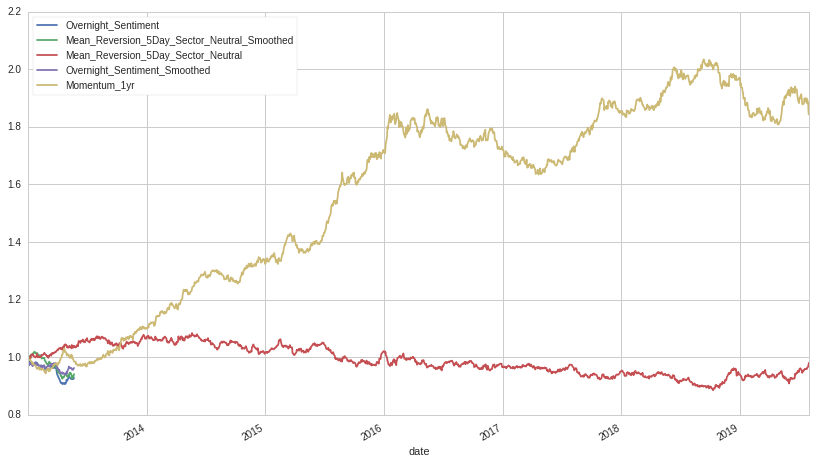

In [65]:
ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:,0]

(1+ls_factor_returns).cumprod().plot();

### BAsis point per Day per Quantile
It is not enought to look just at the factor weighted return. A good alph is alos monotonic in quantiles. Lets look at the basis points for the factor returns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f201dab50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f9e82ae5ed0>]], dtype=object)

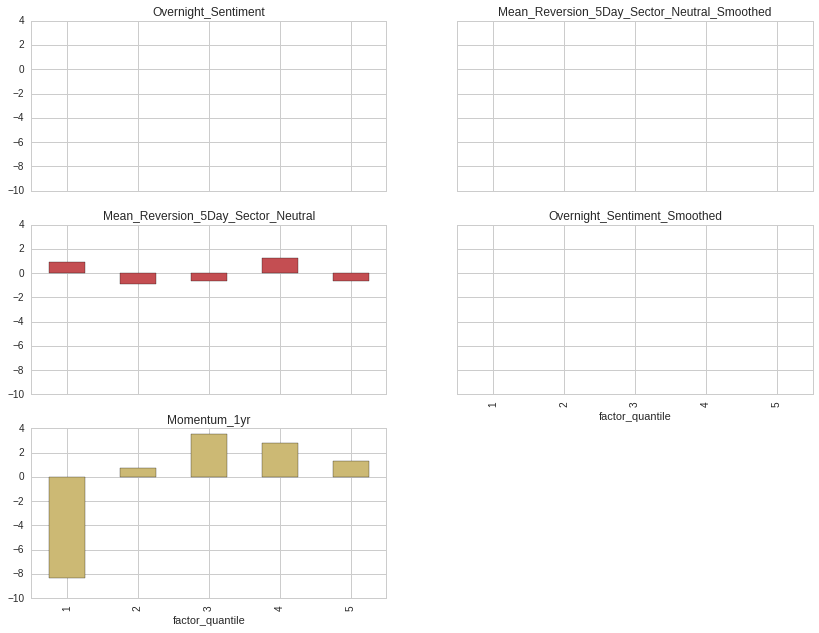

In [72]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False)

What do you observe?

- None of these alphas are **strictly monotonic**; this should lead you to question why this is? Further research and refinement of the alphas needs to be done. What is it about these alphas that leads to the highest ranking stocks in all alphas except MR 5D smoothed to *not* perform the best.
- The majority of the return is coming from the **short side** in all these alphas. The negative return in quintile 1 is very large in all alphas. This could also a cause for concern becuase when you short stocks, you need to locate the short; shorts can be expensive or not available at all.
- If you look at the magnitude of the return spread (i.e., Q1 minus Q5), we are working with daily returns in the 0.03%, i.e., **3 basis points**, neighborhood *before all transaction costs, shorting costs, etc.*. Assuming 252 days in a year, that's 7.56% return annualized. Transaction costs may cut this in half. As such, it should be clear that these alphas can only survive in an institutional setting and that leverage will likely need to be applied in order to achieve an attractive return.

## Turnover Analysis

Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **factor rank autocorrelation (FRA)**.

[alphalens.performance.factor_rank_autocorrelation](https://quantopian.github.io/alphalens/alphalens.html?highlight=factor_rank_autocorrelation#alphalens.performance.factor_rank_autocorrelation)

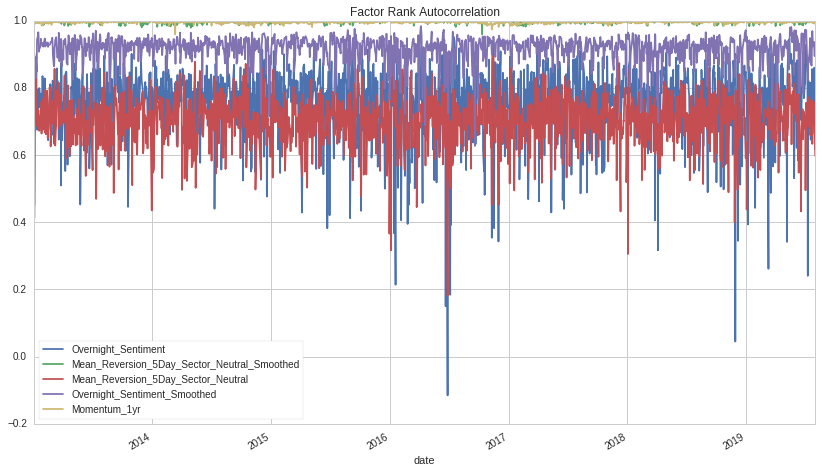

In [74]:
ls_FRA = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

ls_FRA.plot(title="Factor Rank Autocorrelation");

## Sharpe Ratio of the Alphas

The last analysis we'll do on the factors will be sharpe ratio. Implement `sharpe_ratio` to calculate the sharpe ratio of factor returns.

In [77]:
def sharpe_ratio(factor_returns, annualization_factor):
    """
    Get the sharpe ratio for each factor for the entire period

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns for each factor and date
    annualization_factor: float
        Annualization Factor

    Returns
    -------
    sharpe_ratio : Pandas Series of floats
        Sharpe ratio
    """
    
    #TODO: Implement function
    #26-28: Sharpe Ratio - Quiz 1: Sharpe Ratio
    sharpe_ratio = (factor_returns.mean()/factor_returns.std())*annualization_factor
    
    return sharpe_ratio

### View Data
Let's see what the sharpe ratio for the factors are. Generally, a Sharpe Ratio of near 1.0 or higher is an acceptable single alpha for this universe.

In [78]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

Overnight_Sentiment                             NaN
Mean_Reversion_5Day_Sector_Neutral_Smoothed     NaN
Mean_Reversion_5Day_Sector_Neutral            -0.02
Overnight_Sentiment_Smoothed                    NaN
Momentum_1yr                                   1.35
dtype: float64

## Question: What do you think would happen if we smooth the momentum factor? Would the performance increase, decrease, or no major change? Why?

**Answer:** No Impact, looking at the Factor Rank Autocorrelation (FRA) plot we can see that this factor is stable with a value close to 1.

## The Combined Alpha Vector

To use these alphas in a portfolio, we need to combine them somehow so we get a single score per stock. This is a area where machine learning can be very helpful. In this module, however, we will take the simplest approach of combination: simply averaging the scores from each alpha.

In [79]:
selected_factors = all_factors.columns[[1, 2, 4]]
print('Selected Factors: {}'.format(', '.join(selected_factors)))

all_factors['alpha_vector'] = all_factors[selected_factors].mean(axis=1)
alphas = all_factors[['alpha_vector']]
alpha_vector = alphas.loc[all_factors.index.get_level_values(0)[-1]]
alpha_vector.head()

Selected Factors: Mean_Reversion_5Day_Sector_Neutral_Smoothed, Momentum_1yr, Overnight_Sentiment_Smoothed


,alpha_vector
asset,
Equity(24 [AAPL]),-0.077449
Equity(53 [ABMD]),-0.507457
Equity(62 [ABT]),-0.046984
Equity(64 [GOLD]),0.776566
Equity(67 [ADSK]),-0.700337


### Optimal Portfolio Constrained by Risk Model
You have an alpha model and a risk model. Let's find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model. You'll be building thie optimizer for this portfolio. To help you out. we have provided you with an abstract class called `AbstractOptimalHoldings`.

In [102]:
#from abc import ABCMeta, abstractmethod


class AbstractOptimalHoldings(object):    
    # @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
    
    # @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T * weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        #prob.solve(max_iters=100)
        prob.solve()

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

## Objective and Constraints
Using this class as a base class, you'll implement the `OptimalHoldings` class. There's two functions that need to be implemented in this class, the `_get_obj` and `_get_constraints` functions.

The `_get_obj` function should return an CVXPY objective function that maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

The `_get_constraints` function should return a list of the following constraints:
- $ r \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minimum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on individual holdings.

In [103]:
class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)

        #TODO: Implement function
        objective = cvx.Maximize(alpha_vector.values.T * weights)
        return objective
    
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        assert(len(factor_betas.shape) == 2)
        
        #TODO: Implement function
        constraints = [ 
            risk <= self.risk_cap**2,
            factor_betas.T*weights <=self.factor_max,
            factor_betas.T*weights >=self.factor_min,
            sum(weights) == 0.0,
            sum(cvx.abs(weights)) <= 1.0,
            weights >= self.weights_min,
            weights <= self.weights_max,           
        ]
        
        return constraints

    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min

### View Data
With the `OptimalHoldings` class implemented, let's see the weights it generates.

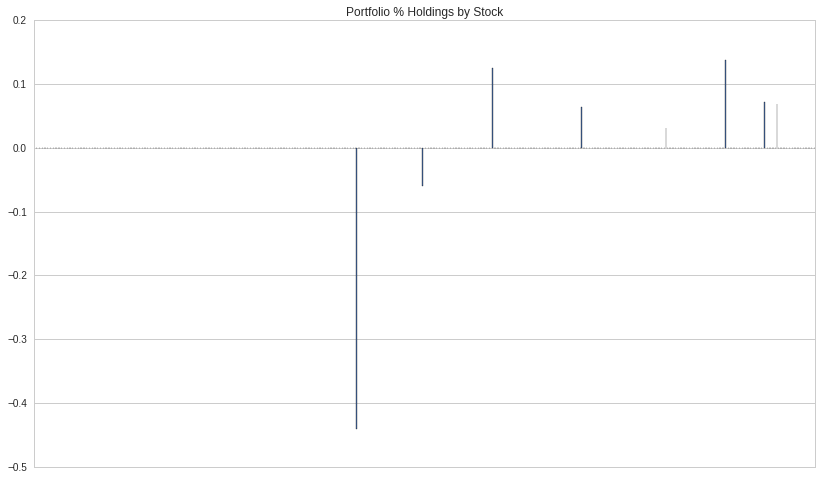

In [104]:
optimal_weights = OptimalHoldings().find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

## Optimize with a Regularization Parameter
In order to enforce diversification, we'll use regularization in the objective function. We'll create a new class called `OptimalHoldingsRegualization` which gets its constraints from the `OptimalHoldings` class. In this new class, implement the `_get_obj` function to return a CVXPY objective function that maximize $ \alpha^T * x + \lambda\|x\|_2\\ $, where $ x $ is the portfolio weights, $ \alpha $ is the alpha vector, and $ \lambda $ is the regularization parameter.

**Note:** * $ \lambda $ is located in `self.lambda_reg`. *

In [105]:
class OptimalHoldingsRegualization(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        #TODO: Implement function
        objective = cvx.Minimize(alpha_vector.values.T * weights + self.lambda_reg * cvx.norm(weights,2))
        # objective = cvx.Maximize(alpha_vector.values.T * weights - self.lambda_reg * cvx.norm(weights,2))
        return objective

    def __init__(self, lambda_reg=0.5, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.lambda_reg = lambda_reg
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min

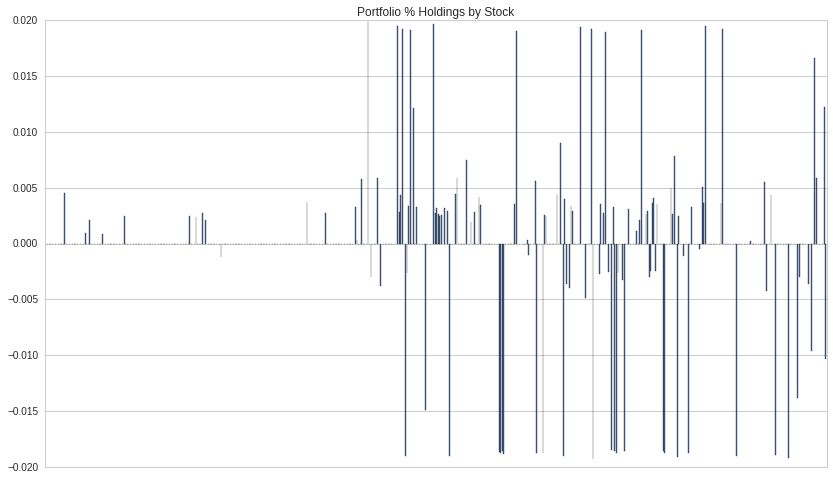

In [106]:
optimal_weights_1 = OptimalHoldingsRegualization(lambda_reg=5.0).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False);

## Optimize with a Strict Factor Constraints and Target Weighting
Another common formulation is to take a predefined target weighting, $x^*$ (e.g., a quantile portfolio), and solve to get as close to that portfolio while respecting portfolio-level constraints. For this next class, `OptimalHoldingsStrictFactor`, you'll implement the `_get_obj` function to minimize on on $ \|x - x^*\|_2 $, where $ x $ is the portfolio weights  $ x^* $ is the target weighting.

In [107]:
class OptimalHoldingsStrictFactor(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        #TODO: Implement function
        alpha_vector_array = alpha_vector.values[:,0]
        
        #21-5 standardizing a factor, sum of these values should be equal to zero
        x_star = (alpha_vector_array - alpha_vector_array.mean()) / sum(abs(alpha_vector_array))
        
        obj = cvx.Minimize(cvx.norm(weights-x_star,2))
        
        return obj

In [108]:
optimal_weights_2 = OptimalHoldingsStrictFactor(
    weights_max=0.02,
    weights_min=-0.02,
    risk_cap=0.0015,
    factor_max=0.015,
    factor_min=-0.015).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_2.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False);

SolverError: Solver 'ECOS' failed. Try another solver.